# Imports

In [349]:
import os
import cv2 as cv
import numpy as np
import scipy.fftpack as fp
import matplotlib.pylab as plt

import pywt
from skimage import color
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import random_noise
from pyunlocbox import functions, solvers
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from skimage.metrics import peak_signal_noise_ratio as psnr

# Utils

In [246]:
def plot_image(img, title, cmap='gray'):
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.title(title, size=10)

def plot_freq_spec_3d(ax, freq):
    Y = np.arange(-freq.shape[0] // 2, freq.shape[0] - freq.shape[0] // 2)
    X = np.arange(-freq.shape[1] // 2, freq.shape[1] - freq.shape[1] // 2)
    X, Y = np.meshgrid(X, Y)
    Z = (20 * np.log10(0.01 + np.fft.fftshift(freq))).real
    ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=True)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_zlim(-40, 120)
    
def plot_img_and_freq(image, title):
    fig = plt.figure(figsize=(9, 4))
    
    plt.subplot(131)
    plot_image(image, title)
    
    ax = fig.add_subplot(132, projection='3d')
    plot_freq_spec_3d(ax, np.fft.fft2(image))

    plt.tight_layout()

In [339]:
def convolve2d(im, psf, k):
    """
    Perform 2D convolution between an image and a point spread function (PSF).

    Parameters:
    - im: numpy.ndarray
        Input image.
    - psf: numpy.ndarray
        Point spread function.
    - k: int
        Size of the PSF kernel.

    Returns:
    - numpy.ndarray
        Convolved image.
    """
    M, N = im.shape
    freq = fp.fft2(im)
    psf = np.pad(psf, (((M - k) // 2, (M - k) // 2 + 1), ((N - k) // 2, (N - k) // 2 + 1)), mode='constant')
    freq_kernel = fp.fft2(fp.ifftshift(psf))
    return np.abs(fp.ifft2(freq * freq_kernel))

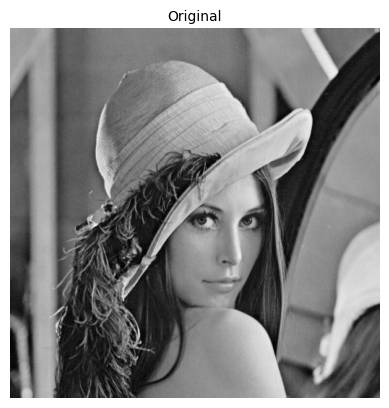

In [341]:
# Reference image
img = cv.imread('images/lena.png', cv.IMREAD_GRAYSCALE)
plot_image(img, 'Original')


## Noise types

In [343]:
# Noise functions for uint8 images
def add_gaussian_noise(image, prob=0.3):
    row, col = image.shape
    # gauss = np.random.normal(mean, sigma, (row, col))
    noisy = image + (prob * image.std() * np.random.standard_normal(image.shape))
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_poisson_noise(image):
    noisy = np.random.poisson(image)
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_sare_si_piper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    noisy = np.copy(image)
    total_pixels = image.size

    # Add salt noise
    salt_pixels = int(total_pixels * salt_prob)
    salt_coords = [np.random.randint(0, i - 1, salt_pixels) for i in image.shape]
    noisy[salt_coords[0], salt_coords[1]] = 255

    # Add pepper noise
    pepper_pixels = int(total_pixels * pepper_prob)
    pepper_coords = [np.random.randint(0, i - 1, pepper_pixels) for i in image.shape]
    noisy[pepper_coords[0], pepper_coords[1]] = 0

    return noisy.astype(np.uint8)

def add_speckle_noise(image):
    speckle = np.random.standard_normal(image.shape)
    noisy = image + image * speckle
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_exponential_noise(image, scale=25):
    expo = np.random.exponential(scale, image.shape)
    noisy = image + expo
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_rayleigh_noise(image, scale=25):
    rayleigh = np.random.rayleigh(scale, image.shape)
    noisy = image + rayleigh
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_uniform_noise(image, low=0, high=50):
    # Quantization noise
    uniform = np.random.uniform(low, high, image.shape)
    noisy = image + uniform
    return np.clip(noisy, 0, 255).astype(np.uint8)

def add_periodic_noise(image, frequency=6, amplitude=50):
    rows, cols = image.shape
    y = np.linspace(0, frequency * 2 * np.pi, rows)
    yy = np.tile(y, (cols, 1)).T  # Tile the y values to cover the entire image horizontally
    noise = amplitude * np.sin(yy)
    noisy = image + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)


In [344]:
noise_types = ['Gaussian', 'Poisson', 'Sare si Piper', 'Speckle', 'Exponential', 'Rayleigh', 'Uniform', 'Periodic']

noisy_images = []
noise_hist = []

# Salvam intr-o lista imaginile cu zgomot si histogramele zgomotelor
for noise_type in noise_types:
    noise_func = globals()[f'add_{noise_type.lower().replace(" ", "_")}_noise']
    noisy_images.append(noise_func(img))
    noise_hist.append((noisy_images[-1] - img).astype(np.uint8))

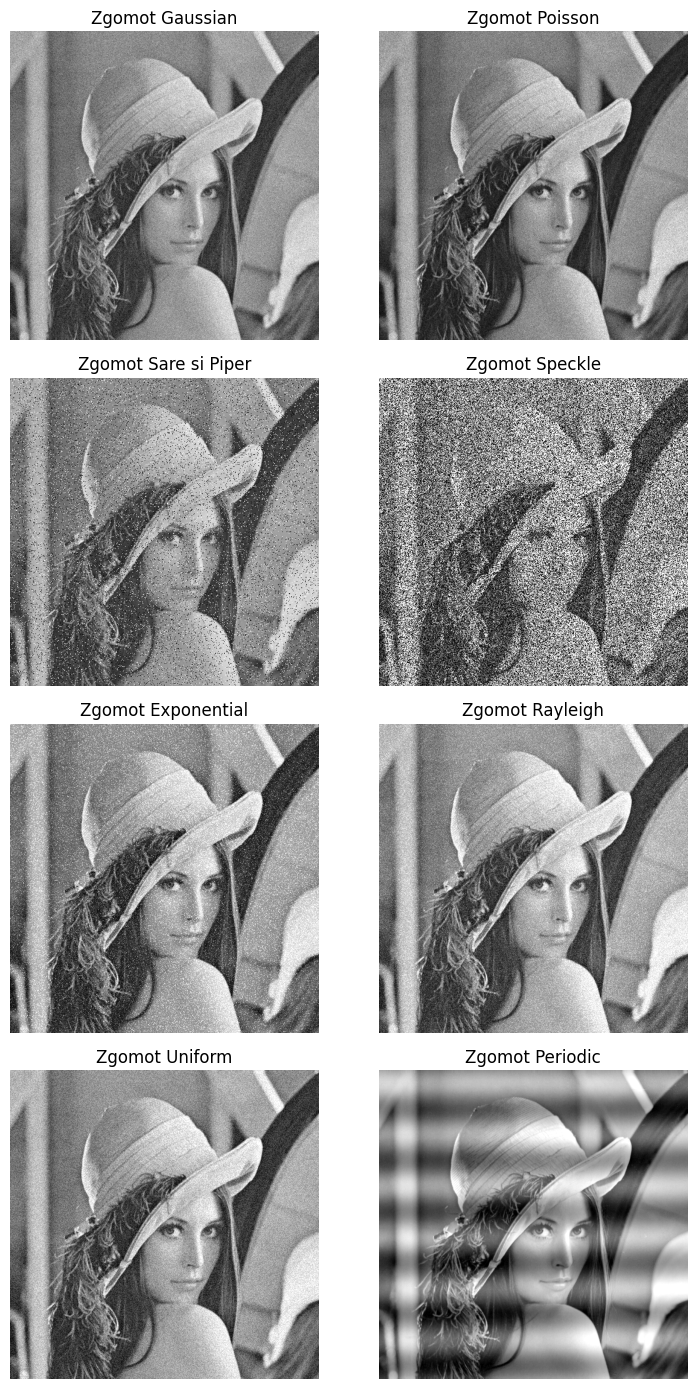

In [345]:
fig, axs = plt.subplots(4, 2, figsize=(8, 14))

for i, im in enumerate(noisy_images):
    axs[i // 2, i % 2].imshow(im, cmap='gray')
    axs[i // 2, i % 2].set_title(f'Zgomot {noise_types[i]}')
    axs[i // 2, i % 2].axis('off')

plt.tight_layout()
# plt.savefig('images/noisy_images.eps', bbox_inches='tight', format='eps')
plt.show() 

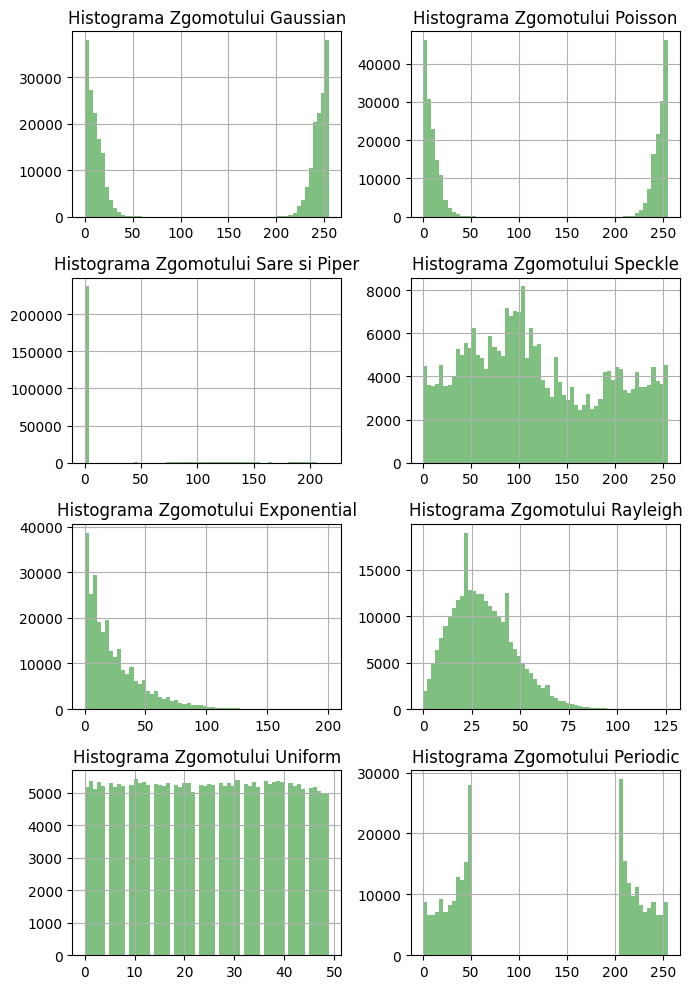

In [346]:
fig, axs = plt.subplots(4, 2, figsize=(7, 10))
for i, noise in enumerate(noise_hist):
    axs[i // 2, i % 2].hist(np.ravel(noise), bins=60, alpha=0.5, color='green')
    axs[i // 2, i % 2].set_title(f'Histograma Zgomotului {noise_types[i]}')
    axs[i // 2, i % 2].grid()
    axs[i // 2, i % 2].tick_params()

plt.tight_layout()
# plt.savefig('images/noise_histograms.eps', bbox_inches='tight', format='eps')
plt.show()

## Linear Filters

In [347]:
def uniform_filter(image, kernel_size):
    pad_size = kernel_size // 2
    padded_image = np.pad(image, pad_width=pad_size, mode='constant', constant_values=0)
    result = np.zeros_like(image)

    for i in range(pad_size, image.shape[0] + pad_size):
        for j in range(pad_size, image.shape[1] + pad_size):
            neighborhood = padded_image[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]
            result[i-pad_size, j-pad_size] = np.mean(neighborhood)

    return result

def median_filter(image, kernel_size):
    pad_size = kernel_size // 2
    padded_image = np.pad(image, pad_width=pad_size, mode='constant', constant_values=0)
    result = np.zeros_like(image)

    for i in range(pad_size, image.shape[0] + pad_size):
        for j in range(pad_size, image.shape[1] + pad_size):
            neighborhood = padded_image[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]
            result[i-pad_size, j-pad_size] = np.median(neighborhood)

    return result

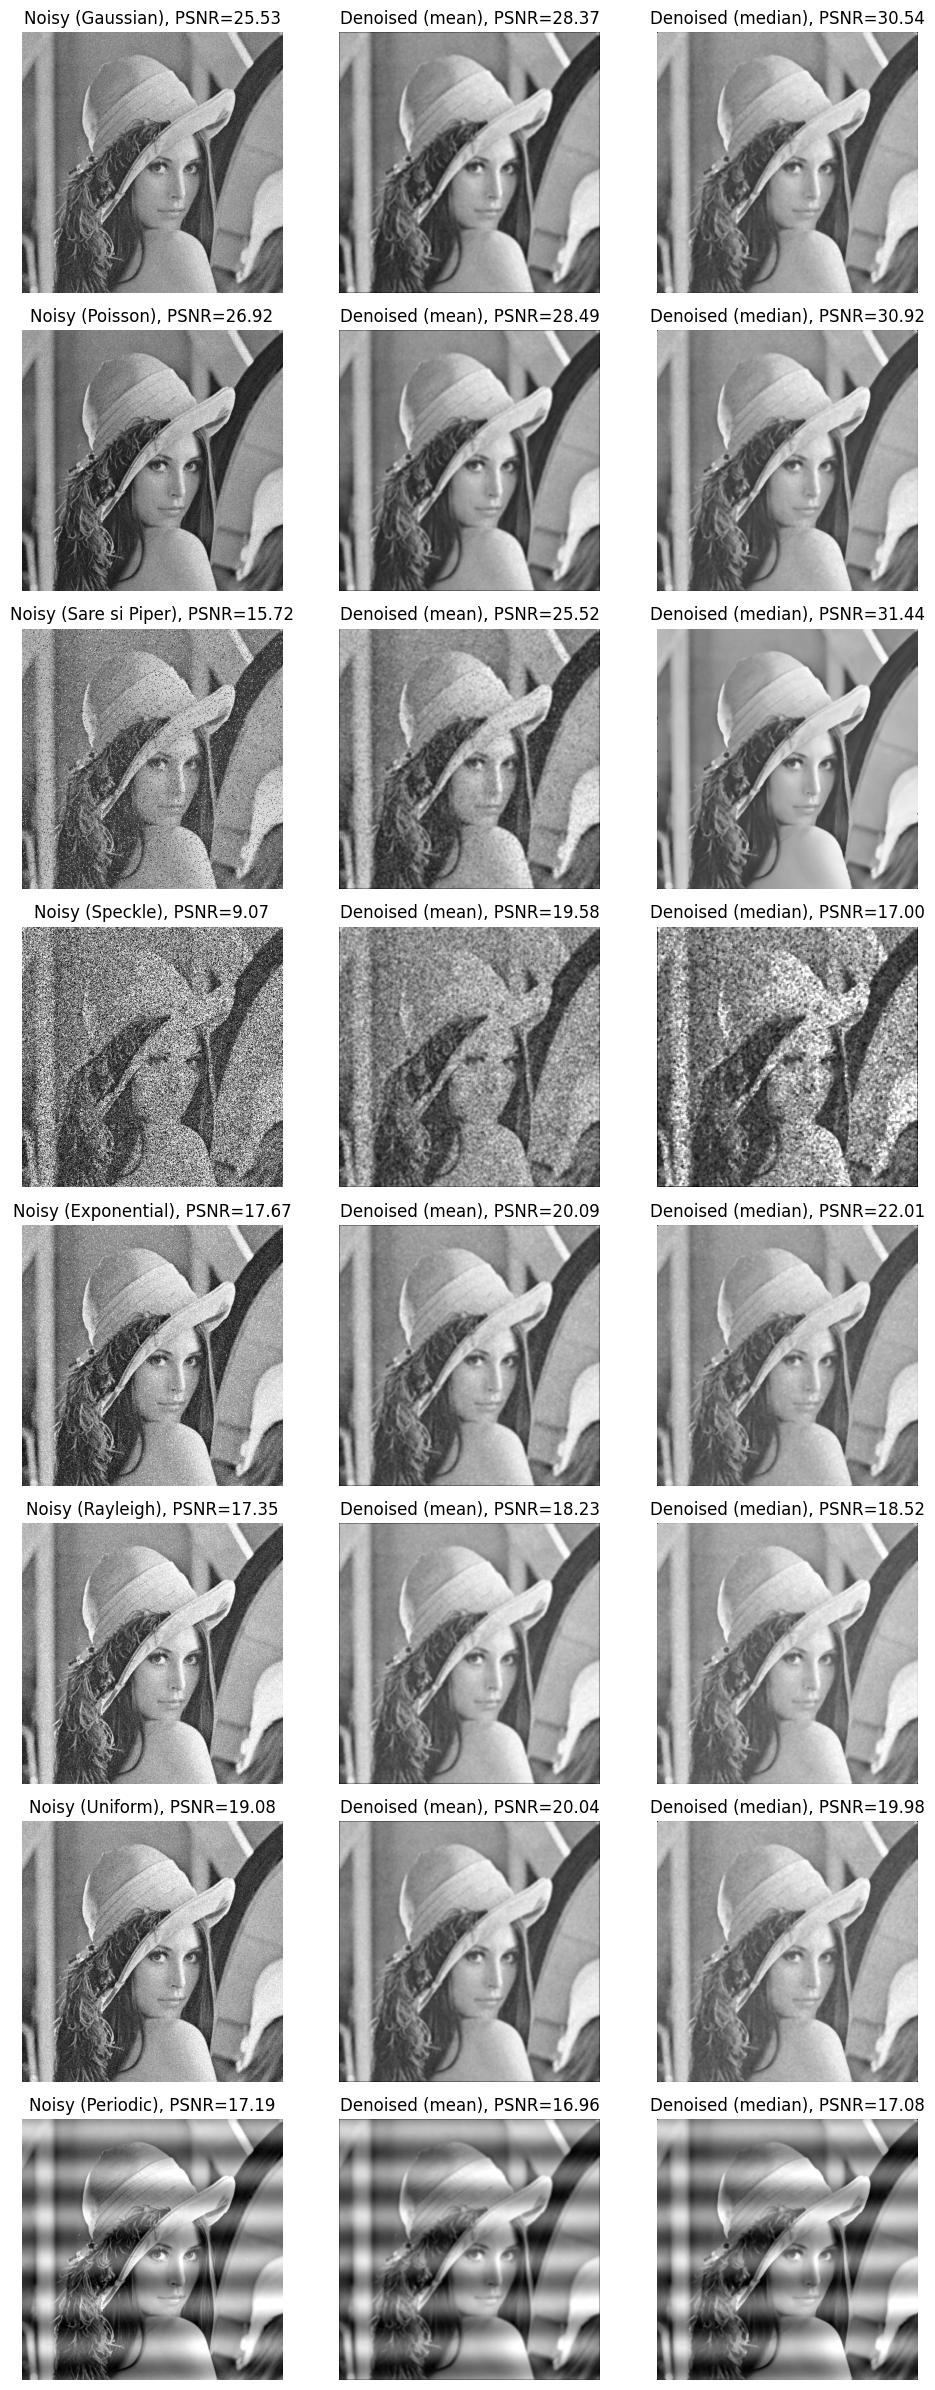

In [350]:
def plot_linear_filters(orig_img, noisy_images: list, noise_types: list, kernel_size=5):
    fig, axs = plt.subplots(len(noisy_images), 3, figsize=(10, 3 * len(noisy_images)))

    for i, noisy_img in enumerate(noisy_images):
        # Noised Image
        axs[i, 0].imshow(noisy_img, cmap='gray')
        axs[i, 0].set_title(f'Noisy ({noise_types[i]}), PSNR={psnr(orig_img, noisy_img):.2f}')
        axs[i, 0].axis('off')

        # Denoised Image (mean)
        filtered_mean = uniform_filter(noisy_img, kernel_size)
        axs[i, 1].imshow(filtered_mean, cmap='gray')
        axs[i, 1].set_title(f'Denoised (mean), PSNR={psnr(orig_img, filtered_mean):.2f}')
        axs[i, 1].axis('off')

        # Denoised Image (median)
        filtered_median = median_filter(noisy_img, kernel_size)
        axs[i, 2].imshow(filtered_median, cmap='gray')
        axs[i, 2].set_title(f'Denoised (median), PSNR={psnr(orig_img, filtered_median):.2f}')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

plot_linear_filters(img, noisy_images, noise_types, kernel_size=5)

# Filtre Spațiale

In [355]:
img = rgb2gray(cv.imread('images/lena.png'))

noisy = img.copy()
noisy += 0.3 * img.std() * np.random.standard_normal(img.shape)

### Discrete Fourier Transform

In [312]:
def dft_2d(img, r=30):
    # Step 1: Apply 2D Fourier Transform
    f_transform = fp.fft2(img)

    # Step 2: Shift the DC component to the center
    f_transform_shifted = fp.fftshift(f_transform)

    # Visualization after Step 2
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(np.log(np.abs(f_transform_shifted) + 1), cmap='gray')
    plt.title('Shifted Fourier Transform'), plt.axis('off')

    # Step 3: Design an ideal low-pass filter
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    center = [crow, ccol]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 > r*r
    mask[mask_area] = 0

    # Visualization after Step 3
    plt.subplot(122), plt.imshow(mask, cmap='gray')
    plt.title('Low-pass Filter'), plt.axis('off')
    plt.suptitle('Step 3: Designing Low-pass Filter', size=16)
    plt.show()

    # Step 4: Apply the filter
    f_transform_shifted_filtered = f_transform_shifted * mask

    # Visualization after Step 4
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(np.log(np.abs(f_transform_shifted_filtered) + 1), cmap='gray')
    plt.title('Filtered Fourier Transform'), plt.axis('off')

    # Step 5: Inverse Fourier Transform
    img_denoised = np.fft.ifft2(np.fft.ifftshift(f_transform_shifted_filtered)).real

    # Visualization after Step 5
    plt.subplot(122), plt.imshow(img_denoised, cmap='gray')
    plt.title('Inverse Fourier Transform'), plt.axis('off')
    plt.suptitle('Step 5: Inverse Fourier Transform and Denoised Image', size=16)
    plt.show()

    return img_denoised

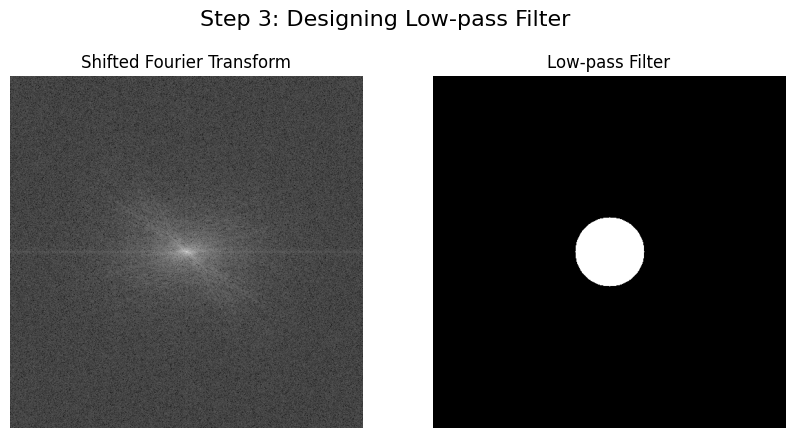

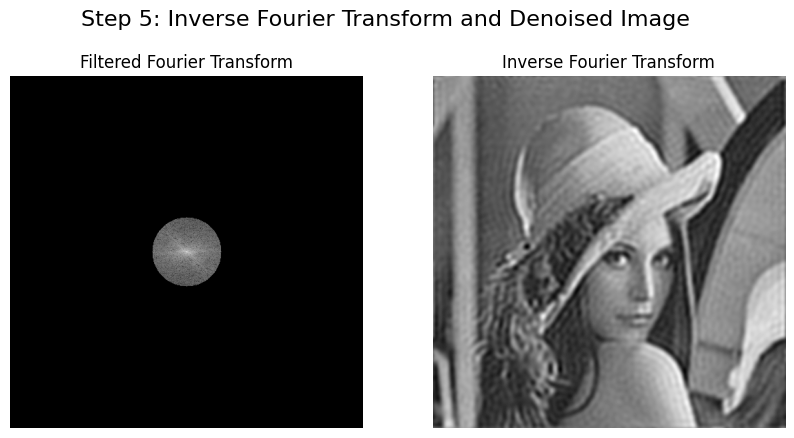

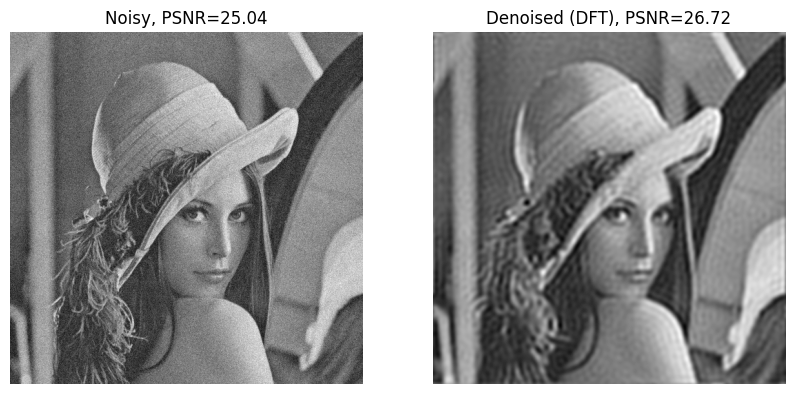

In [319]:
denoised = dft_2d(noisy, r=50)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(noisy, cmap='gray')
axs[0].set_title(f'Noisy, PSNR={psnr(img, noisy):.2f}')
axs[0].axis('off')

axs[1].imshow(denoised, cmap='gray')
axs[1].set_title(f'Denoised (DFT), PSNR={psnr(img, denoised):.2f}')
axs[1].axis('off')

plt.show()


### Discrete Wavelet Transform

In [ ]:
!pip install PyWavelets

In [324]:
# https://asp-eurasipjournals.springeropen.com/articles/10.1186/s13634-020-00693-4
def dwt_denoise(img, wavelet='haar', level=1):
    """
    Apply denoising using Discrete Wavelet Transform (DWT) to the input image.

    Parameters:
    - img: Input image to be denoised.
    - wavelet: Wavelet function to be used for DWT. Default is 'haar'.
    - level: Number of decomposition levels for DWT. Default is 1.

    Returns:
    - img_denoised: Denoised image after applying DWT.

    """
    # Step 1: Decompose the image using DWT
    coeffs = pywt.wavedec2(img, wavelet, level=level)

    # Step 2: Set threshold for denoising
    threshold = 20
    
    # Step 3: Threshold the detail coefficients
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') if i > 0 else c for i, c in enumerate(coeffs)]

    coeffs_thresholded_explicit = [tuple(coeffs_thresholded[0])] + [tuple(c) for c in coeffs_thresholded[1:]]

    # Step 4: Reconstruct the denoised image
    img_denoised = pywt.waverec2(coeffs_thresholded_explicit, wavelet)


    return img_denoised

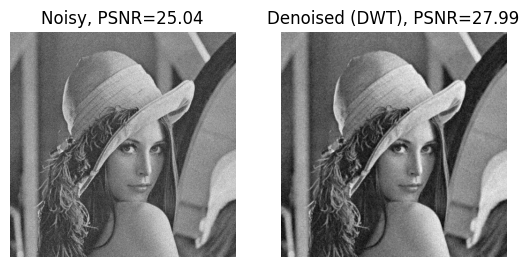

In [337]:
denoised = dwt_denoise(noisy, level=1)

plt.subplot(121), plt.imshow(noisy, cmap='gray')
plt.title(f'Noisy, PSNR={psnr(img, noisy):.2f}'), plt.axis('off')
plt.subplot(122), plt.imshow(denoised, cmap='gray')
plt.title(f'Denoised (DWT), PSNR={psnr(img, denoised):.2f}'), plt.axis('off')
plt.show()

# Filtrul Wiener

In [338]:
def wiener(image, psf, balance=0.1):
    """
    Applies Wiener deconvolution to restore an image degraded by a point spread function (PSF).

    Parameters:
    - image: numpy.ndarray
        The input degraded image.
    - psf: numpy.ndarray
        The point spread function.
    - balance: float, optional
        The balance parameter used to control the trade-off between noise amplification and image restoration.
        Default value is 0.1.

    Returns:
    - numpy.ndarray
        The restored image.

    """
    image_freq = fp.fft2(image)

    M, N = image.shape
    psf = np.pad(psf, (((M - psf.shape[0]) // 2, (M - psf.shape[0]) // 2 + 1),
                       ((N - psf.shape[1]) // 2, (N - psf.shape[1]) // 2 + 1)), mode='constant')
 
    psf_freq = fp.fft2(fp.ifftshift(psf))
    wiener_filter = np.conj(psf_freq) / (np.abs(psf_freq) ** 2 + balance)
    restored_freq = image_freq * wiener_filter
    restored_image = np.abs(fp.ifft2(restored_freq))

    return restored_image

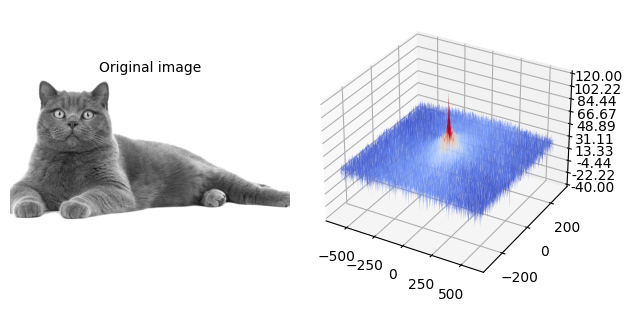

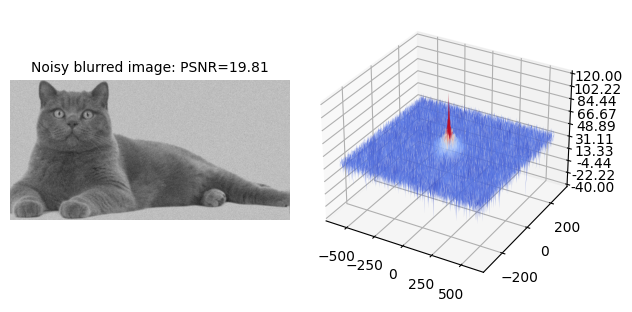

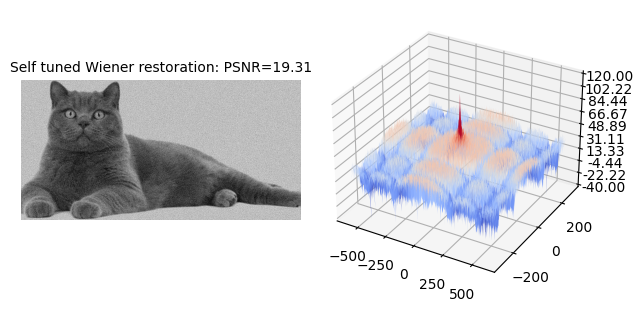

In [359]:
k = 5
psf = np.ones((k, k)) / k ** 2

img = rgb2gray(imread('images/cat.jpeg'))
img1 = convolve2d(img, psf, k)
img1 += 0.3 * img.std() * np.random.standard_normal(img.shape)
img2 = wiener(img1, psf, balance=0.1)

titles = [
    'Original image',
    f'Noisy blurred image: PSNR={psnr(img, img1):.2f}',
    f'Self tuned Wiener restoration: PSNR={psnr(img, img2):.2f}',
]
images = [img, img1, img2]

for i in range(3):
    plot_img_and_freq(images[i], titles[i])
    # plt.savefig(os.path.join('images', f"wiener_im{i+1}.eps"), bbox_inches='tight')
    plt.show()
    

## Constrained Least Squares (CLS) Filter

In [361]:
def cls_filter(y, h, c, lambd):
    Hf = fp.fft2(fp.ifftshift(h))
    Cf = fp.fft2(fp.ifftshift(c))
    Hf_conj = np.conj(Hf)
    Hf = Hf_conj / (Hf * Hf_conj + lambd * Cf * np.conj(Cf))
    Yf = fp.fft2(y)
    I = Yf * Hf
    return np.abs(fp.ifft2(I))

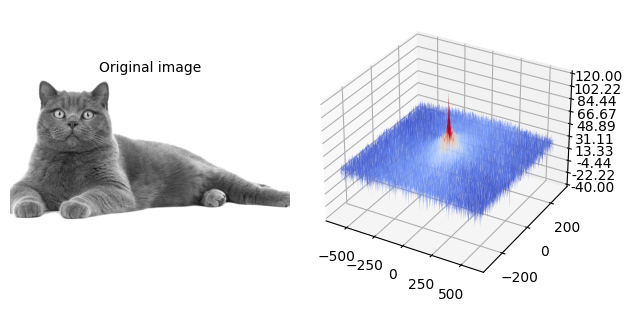

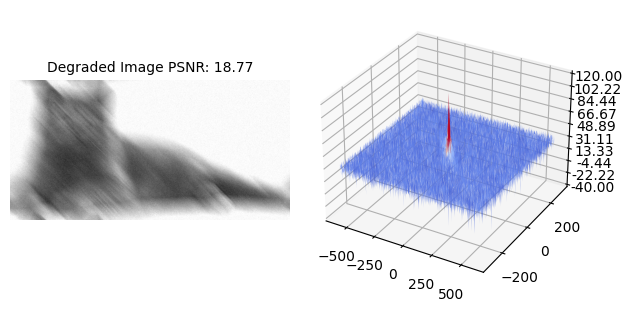

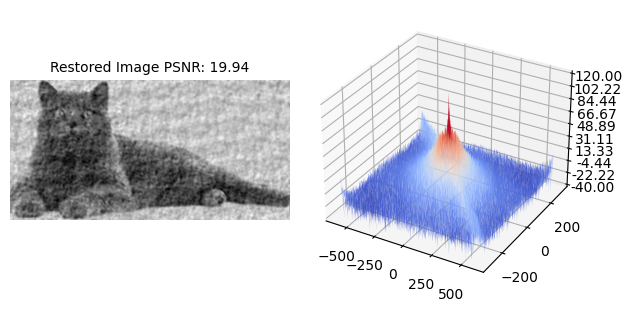

In [363]:
im = rgb2gray(imread('images/cat.jpeg'))

(M, N), k = im.shape, 81
kernel = np.eye(k) / k
im_blur = convolve2d(im, kernel, k)
im_blur = random_noise(im_blur, var=0.0025)

x, y, h = im, im_blur, kernel

pad_rows = (M // 2 - k // 2, M // 2 - k // 2 - 1)
pad_cols = (N // 2 - k // 2, N // 2 - k // 2 - 1)
h = np.pad(h, [pad_rows, pad_cols], mode='constant')

c = np.pad([[0, 1 / 4, 0], [1 / 4, -1, 1 / 4], [0, 1 / 4, 0]], [(M // 2 - 1, M // 2 - 2), (N // 2 - 2, N // 2 - 1)], mode='constant')
Cf = fp.fft2(fp.ifftshift(c))

_lambda = 2
clx = cls_filter(y, h, c, _lambda)

titles = [
    'Original image',
    f'Degraded Image PSNR: {psnr(x, y):.2f}',
    f'Restored Image PSNR: {psnr(x, clx):.2f}'
]
images = [im, im_blur, clx]

for i in range(3):
    plot_img_and_freq(images[i], titles[i])
    # plt.savefig(os.path.join('images', f"cls_im{i+1}.eps"), bbox_inches='tight')
    plt.show()


## Markov Random Field

In [364]:
def read_image_and_binarize(image_file, threshold=128):
    im = (255 * rgb2gray(plt.imread(image_file))).astype(int)
    im[im < threshold] = -1
    im[im >= threshold] = 1
    return im


def add_noise(im):
    im_noisy = im.copy()
    for i in range(im_noisy.shape[0]):
        for j in range(im_noisy.shape[1]):
            r = np.random.rand()
            if r < 0.1:
                im_noisy[i][j] = -im_noisy[i][j]
    return im_noisy


def compute_energy_helper(Y, i, j):
    try:
        return Y[i][j]
    except IndexError:
        return 0


def compute_energy(X, Y, i, j, zeta, eta, Y_i_j):
    energy = -eta * X[i][j] * Y_i_j
    for (k, l) in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        energy -= zeta * Y_i_j * compute_energy_helper(Y, i + k, j + l)
    return energy


def denoise_image(O, X, zeta, eta):
    m, n = np.shape(X)
    Y = np.copy(X)
    max_iter = 10 * m * n

    for iter in range(max_iter):
        i = np.random.randint(m)
        j = np.random.randint(n)

        energy_neg = compute_energy(X, Y, i, j, zeta, eta, -1)
        energy_pos = compute_energy(X, Y, i, j, zeta, eta, 1)

        if energy_neg < energy_pos:
            Y[i][j] = -1
        else:
            Y[i][j] = 1

    return Y

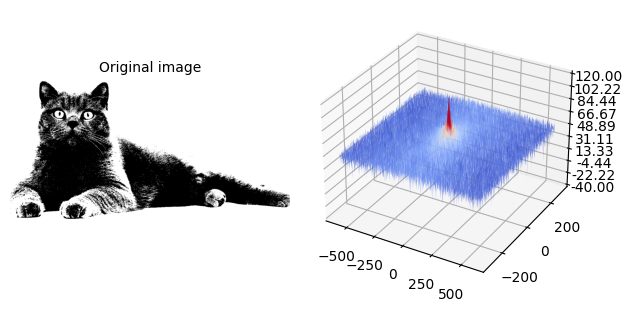

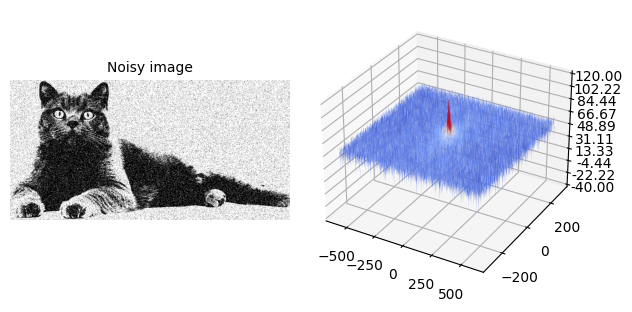

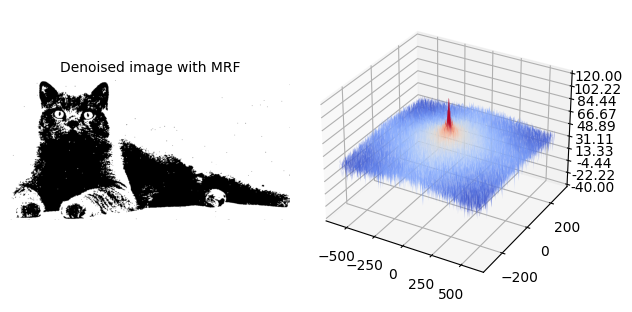

In [365]:
orig_image = read_image_and_binarize('images/cat.jpeg')
zeta = 1.5
eta = 2

noisy_image = add_noise(orig_image)
denoised_image = denoise_image(orig_image, noisy_image, zeta, eta)

titles = [
    'Original image',
    'Noisy image',
    'Denoised image with MRF'
]
images = [orig_image, noisy_image, denoised_image]

for i in range(3):
    plot_img_and_freq(images[i], titles[i])